In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skopt import BayesSearchCV

from xgboost import XGBClassifier

%matplotlib inline

In [2]:
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [3]:
df = pd.read_csv('./data/all_categoricals.csv', index_col = 0)

In [4]:
!ls data

aac_intakes.csv          df_cat.csv               hour_ids.csv
aac_intakes_outcomes.csv df_dog.csv               hr_name.csv
aac_outcomes.csv         df_mod.csv               master_df.csv
all_categoricals.csv     engineered.csv           master_df_1128.csv
concat_backup.csv        group_shade.csv          master_df_1129.csv


In [5]:
df_name_hour = pd.read_csv('./data/hr_name.csv', index_col=0)

In [6]:
df_group_shade = pd.read_csv('./data/group_shade.csv', index_col=0)

In [7]:
df_group_shade.head()

,age,animal_id,animal_type,datetime_in,days_in_shelter,dow,fixed_status,gender,group,intake_condition,intake_season,intake_type,mix,name,outcome_type,simple_color,hour_in,simple_group,shade
0,2920,A706918,Dog,2015-07-05 12:59:00,0,6,fixed,1,Sporting,Normal,summer,Stray,0,1,Return to Owner,White,12,Sporting,Light
1,330,A724273,Dog,2016-04-14 18:43:00,6,3,intact,0,Hound,Normal,spring,Stray,1,1,Return to Owner,Sable,18,Non-Sporting,Light
2,1460,A682524,Dog,2014-06-29 10:38:00,3,6,fixed,0,Working,Normal,spring,Stray,1,1,Return to Owner,Yellow,10,Non-Sporting,Light
3,730,A743852,Dog,2017-02-18 12:46:00,3,5,fixed,0,Sporting,Normal,winter,Owner Surrender,1,1,Return to Owner,Brown,12,Sporting,Medium
4,730,A708452,Dog,2015-07-30 14:37:00,5,3,intact,0,Sporting,Normal,summer,Public Assist,1,1,Return to Owner,Black,14,Sporting,Dark


In [8]:
df_group_shade = df_group_shade[['animal_id', 'simple_group', 'shade']]

In [9]:
df = df_name_hour.drop(labels=['name'], axis=1).merge(df, on='animal_id')

In [10]:
df = df_group_shade.merge(df, on='animal_id')

In [13]:
df = df[df['outcome_type'] != 'Rto-Adopt']
df = df[df['outcome_type'] != 'Missing']
df = df[df['outcome_type'] != 'Disposal']

In [14]:
# We don't need animal id for modeling
df_model = df.iloc[:, 1:]

In [15]:
df_model = df_model[~df_model.duplicated()]

In [16]:
df['outcome_type'].value_counts()

Adoption           33455
Transfer           22946
Return to Owner    14938
Euthanasia          2873
Died                 540
Name: outcome_type, dtype: int64

In [17]:
df_model['outcome_type'].value_counts()

Adoption           32562
Transfer           20458
Return to Owner    14518
Euthanasia          2847
Died                 532
Name: outcome_type, dtype: int64

Drop the days in shelter feature for now. This will be used later in regression analysis if needed.

In [18]:
df_model = df_model.drop(labels=['days_in_shelter'], axis=1)

In [19]:
df_model.head()

,simple_group,shade,name_freq,hour,age,dow,gender,mix,name,animal_type_Cat,...,hour_in_22,hour_in_23,hour_in_3,hour_in_4,hour_in_5,hour_in_6,hour_in_7,hour_in_8,hour_in_9,outcome_type
0,Sporting,Light,52,12,2920,6,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Return to Owner
1,Non-Sporting,Light,1,18,330,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Return to Owner
2,Non-Sporting,Light,22,10,1460,6,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Return to Owner
3,Sporting,Medium,32,12,730,5,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Return to Owner
4,Sporting,Dark,1,14,730,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Return to Owner


In [20]:
df_model.columns.values

array(['simple_group', 'shade', 'name_freq', 'hour', 'age', 'dow',
       'gender', 'mix', 'name', 'animal_type_Cat', 'animal_type_Dog',
       'fixed_status_fixed', 'fixed_status_intact', 'group_Herding',
       'group_Hound', 'group_Non-Sporting', 'group_Sporting',
       'group_Terrier', 'group_Toy', 'group_Working', 'group_long hair',
       'group_short hair', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_season_fall',
       'intake_season_spring', 'intake_season_summer',
       'intake_season_winter', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'simple_color_Black', 'simple_color_Blue',
       'simple_color_Brown', 'simple_color_Gray', 'simple_color_Red',
       'simple_color_Sable', 'simple_col

In [21]:
df_model = df_model.drop(labels=['hour_in_0',
       'hour_in_1', 'hour_in_10', 'hour_in_11', 'hour_in_12',
       'hour_in_13', 'hour_in_14', 'hour_in_15', 'hour_in_16',
       'hour_in_17', 'hour_in_18', 'hour_in_19', 'hour_in_2',
       'hour_in_20', 'hour_in_21', 'hour_in_22', 'hour_in_23',
       'hour_in_3', 'hour_in_4', 'hour_in_5', 'hour_in_6', 
       'hour_in_7', 'hour_in_8', 'hour_in_9'], axis=1)

In [37]:
df_model = df_model.drop(labels=['intake_season_fall', 'intake_season_spring', 'intake_season_summer'], axis=1)

In [38]:
df_model.columns.values

array(['simple_group_Non-Sporting', 'simple_group_Sporting',
       'simple_group_long hair', 'simple_group_short hair', 'shade_Dark',
       'shade_Light', 'shade_Medium', 'name_freq', 'hour', 'age', 'dow',
       'gender', 'mix', 'animal_type_Cat', 'animal_type_Dog',
       'fixed_status_fixed', 'fixed_status_intact',
       'intake_condition_Aged', 'intake_condition_Feral',
       'intake_condition_Injured', 'intake_condition_Normal',
       'intake_condition_Nursing', 'intake_condition_Other',
       'intake_condition_Pregnant', 'intake_condition_Sick',
       'intake_season_winter', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'outcome_type'], dtype=object)

In [23]:
df_model = df_model.drop(labels=['name'], axis=1)

In [24]:
df_model = df_model.drop(labels=['simple_color_Black', 'simple_color_Blue',
       'simple_color_Brown', 'simple_color_Gray', 'simple_color_Red',
       'simple_color_Sable', 'simple_color_Tricolor',
       'simple_color_White', 'simple_color_Yellow', 'group_Herding',
       'group_Hound', 'group_Non-Sporting', 'group_Sporting',
       'group_Terrier', 'group_Toy', 'group_Working', 'group_long hair',
       'group_short hair'], axis=1)

In [25]:
df_model.head()

,simple_group,shade,name_freq,hour,age,dow,gender,mix,animal_type_Cat,animal_type_Dog,...,intake_condition_Sick,intake_season_fall,intake_season_spring,intake_season_summer,intake_season_winter,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,outcome_type
0,Sporting,Light,52,12,2920,6,1,0,0,1,...,0,0,0,1,0,0,0,0,1,Return to Owner
1,Non-Sporting,Light,1,18,330,3,0,1,0,1,...,0,0,1,0,0,0,0,0,1,Return to Owner
2,Non-Sporting,Light,22,10,1460,6,0,1,0,1,...,0,0,1,0,0,0,0,0,1,Return to Owner
3,Sporting,Medium,32,12,730,5,0,1,0,1,...,0,0,0,0,1,0,1,0,0,Return to Owner
4,Sporting,Dark,1,14,730,3,0,1,0,1,...,0,0,0,1,0,0,0,1,0,Return to Owner


In [26]:
df_model = pd.concat([pd.get_dummies(df[['simple_group', 'shade']]), df_model.drop(labels=['simple_group', 'shade'],
                                                                       axis=1)], axis=1)

In [27]:
df_model = df_model.dropna()

In [28]:
df_model.shape

(70917, 34)

In [39]:
X = df_model.iloc[:, :-1]

In [40]:
y = df_model.iloc[:, -1]

In [41]:
le = LabelEncoder()
le.fit(y)

LabelEncoder()

In [42]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return to Owner', 'Transfer'],
      dtype=object)

In [43]:
y = le.transform(y)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 2325)

In [35]:
rf_cv = RandomForestClassifier(n_estimators = 800, max_features='sqrt', max_leaf_nodes=50,
                               max_depth = 100)

rf_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=50,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

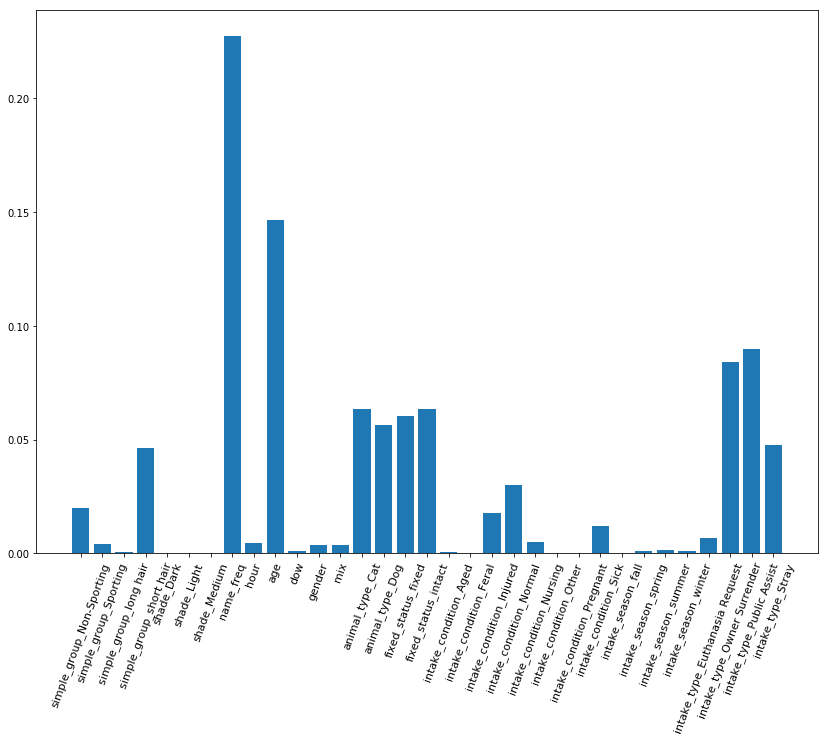

In [36]:
plt.figure(figsize=(14, 10))
plt.bar(X_train.columns.values, rf_cv.feature_importances_)
plt.xticks(rotation=70, size=11);

In [ ]:
rfc = RandomForestClassifier()

tuning_params_rf = {'n_estimators': [300, 800], 'max_features': ['sqrt'], 'max_leaf_nodes': [150, 200],
                    'max_depth': [50, 200]}

bs = BayesSearchCV(rfc, tuning_params_rf, n_jobs=-1, n_iter = 20, scoring='f1_micro', cv=3)

bs.fit(X_train, y_train)

In [ ]:
bs.best_score_

In [ ]:
bs.best_params_

## XGBoost hyperparameter tuning

In [48]:
xg = XGBClassifier(n_jobs = -1)

tuning_params = {'max_depth': [5, 90], 'learning_rate': [0, 1], 'objective': ['multi:softprob'],
                 'min_child_weight': [1, 3, 5]}

bs = BayesSearchCV(xg, tuning_params, cv=3, verbose=True, scoring = 'f1_micro', n_jobs=-1, n_iter = 10)

bs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='f1_micro',
       search_spaces={'max_depth': [5, 90], 'learning_rate': [0, 1], 'objective': ['multi:softprob'], 'min_child_weight': [1, 3, 5]},
       verbose=True)

In [49]:
bs.best_params_

{'learning_rate': 1,
 'max_depth': 10,
 'min_child_weight': 3,
 'objective': 'multi:softprob'}

In [50]:
bs.best_score_

0.6031361046872356

In [56]:
pipe = make_pipeline(StandardScaler(), XGBClassifier(learning_rate=1, max_depth=10, min_child_weight=3,
                                                    objective='multi:softprob'))

In [ ]:
scores = cross_val_score(pipe, cv=3, n_jobs = -1, scoring='f1_micro', X=X_train, y=y_train)

In [ ]:
scores